In [1]:
import os
os.chdir("..")

In [2]:
from mlengine.config.settings import settings
from mlengine.common.logger import logger

2023-11-14 23:03:24 DESKTOP-PEC6JQ0 11_14_2023_23_03_24.log[7308] INFO Logging initialized.
******************************
2023-11-14 23:03:24 DESKTOP-PEC6JQ0 11_14_2023_23_03_24.log[7308] INFO Settings file [d:\PycharmProjects\ml-app\src\mlengine\config\settings.yaml] loaded successfully.
******************************


In [3]:
import pandas as pd
import pydantic

In [4]:
data_validation_settings = settings.data_validation

In [6]:
df = pd.read_csv(data_validation_settings.req_files[0], delimiter=',')

In [7]:
class DataValidator(pydantic.BaseModel):
    gender: pydantic.StrictStr
    race_ethnicity: pydantic.StrictStr
    parental_level_of_education: pydantic.StrictStr
    lunch: pydantic.StrictStr
    test_preparation_course: pydantic.StrictStr
    math_score: pydantic.StrictInt
    reading_score: pydantic.StrictInt
    writing_score: pydantic.StrictInt

In [8]:
data_list = [DataValidator(**row) for _, row in df.iterrows()]

In [9]:
df.isna().sum()

gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [12]:
print(df.nunique())

gender                          2
race_ethnicity                  5
parental_level_of_education     6
lunch                           2
test_preparation_course         2
math_score                     81
reading_score                  72
writing_score                  77
dtype: int64


In [13]:
df.describe()

,math_score,reading_score,writing_score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [14]:
df['total_score'] = df['math_score'] + df['reading_score'] + df['writing_score']
df['average'] = df['total_score']/3
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667
1,female,group C,some college,standard,completed,69,90,88,247,82.333333
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333
4,male,group C,some college,standard,none,76,78,75,229,76.333333


In [15]:
df['average'].skew()

-0.29905711750168584

In [16]:
df['average'].kurt()

0.12584287362370628

In [17]:
from mlengine.plots.dist import histograms_across_feats, distplots_across_feats, plot_features

In [153]:
plot_features(df)

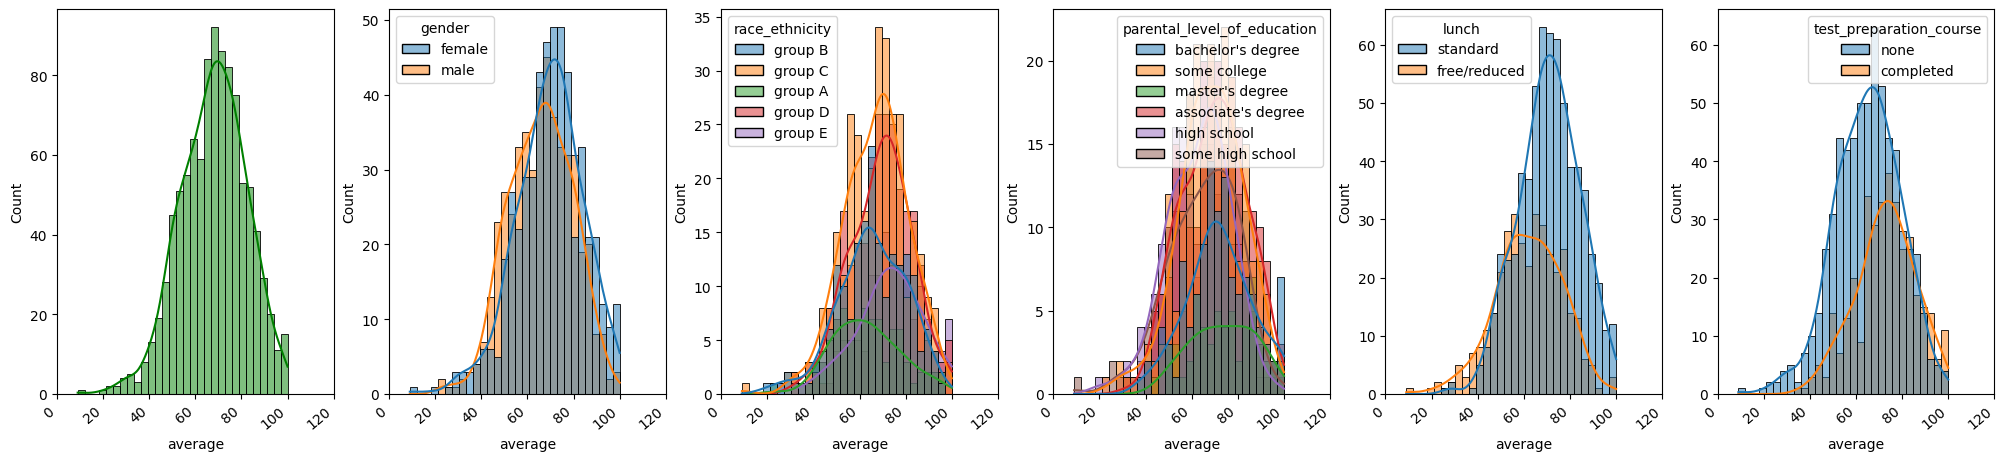

In [18]:
histograms_across_feats(df, column='average')

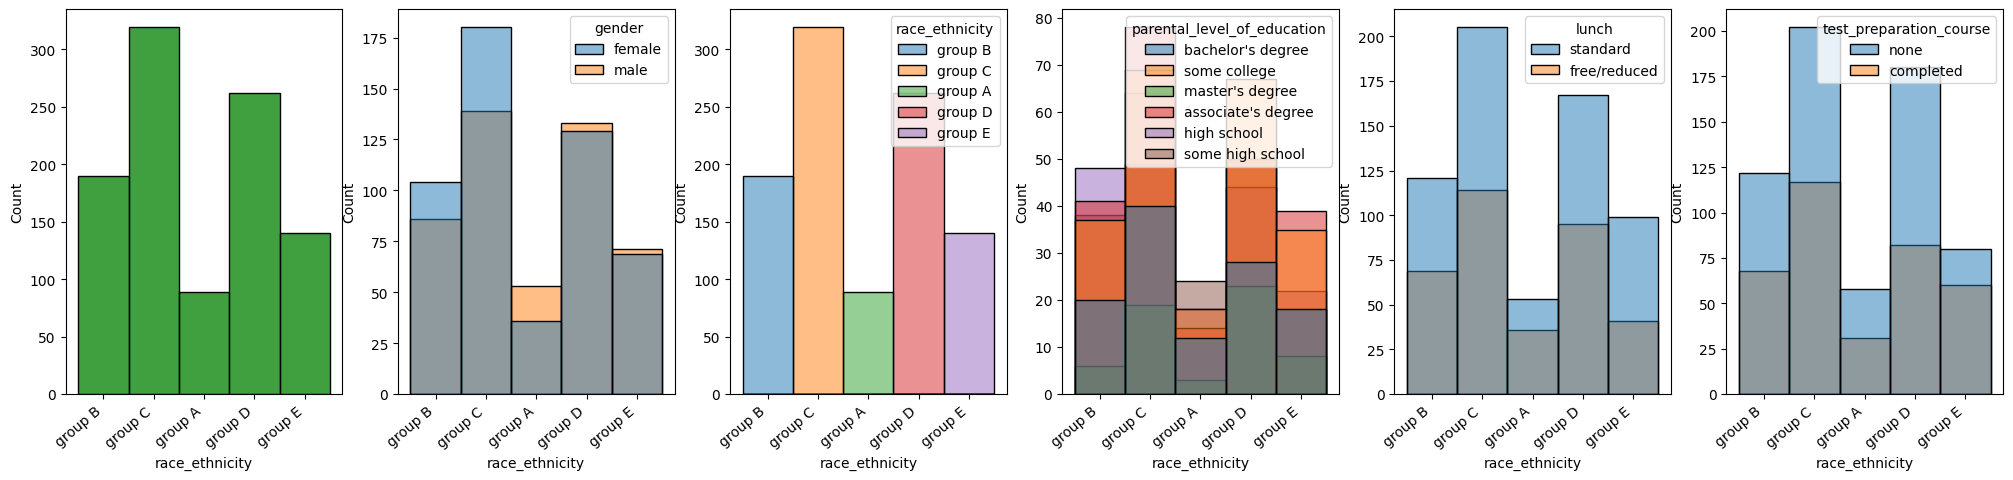

In [19]:
histograms_across_feats(df, column='race_ethnicity')

In [20]:
distplots_across_feats(df, column='average', mode='box') # box, violin, rug